In this code we run a discriminator classification model to see how well it can distinguish between real and synthetic data.

In [ ]:
!pip3 install catboost

In [ ]:
# Downgrade NumPy to be compatible with CatBoost
!pip install numpy==1.24.4

# Downgrade pandas to the version required by Google Colab
!pip install pandas==2.2.2

# Restart the runtime after installation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
df_syn_gpt = pd.read_csv("/content/combined_data_gpt.csv") # contains 100K rows of click = 1 and click = 0 generated using GPT3
df_syn_tab = pd.read_csv("/content/combined_data_tab.csv") # contains 20K rows of click = 1 and click = 0 generated using REalTabFormer
df_real = pd.read_csv("/content/combined_data.csv") # contains around 240K rows of original target ad data

In [ ]:
print(f"Total rows of data in target: {df_real.shape[0]}")
print(f"Total rows in data in synthetic data generated by gpt: {df_syn_gpt.shape[0]}")
print(f"Total rows in data in synthetic data generated by tab: {df_syn_tab.shape[0]}")

Total rows of data in target: 239136
Total rows in data in synthetic data generated by gpt: 100000
Total rows in data in synthetic data generated by tab: 20000


Examining the plots of some variables in the real and synthetic data to look at their distribution to see how closely they match

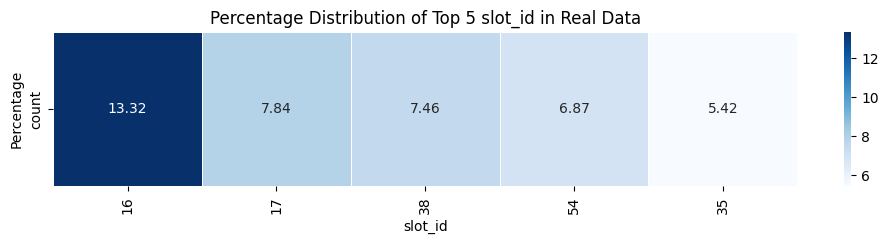

In [ ]:
# Get the top 5 most frequent 'slot_id's in both DataFrames combined
top_5_slot_ids = df_real['slot_id'].value_counts().head(5)

# Calculate the percentage for each of the top 10 most frequent 'slot_id's
total_rows = len(df_real)
top_5_slot_ids_percentage = (top_5_slot_ids / total_rows) * 100

# Convert the percentages to a DataFrame suitable for heatmap
top_5_slot_ids_percentage_df = top_5_slot_ids_percentage.to_frame().T  # Transpose to have one row

# Plot the heatmap for the top 5 most frequent 'slot_id's with percentages
plt.figure(figsize=(12, 2))  # Adjust figure size
sns.heatmap(top_5_slot_ids_percentage_df, annot=True, cmap='Blues', cbar=True, fmt='.2f', linewidths=0.5)
plt.title('Percentage Distribution of Top 5 slot_id in Real Data')
plt.xlabel('slot_id')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()



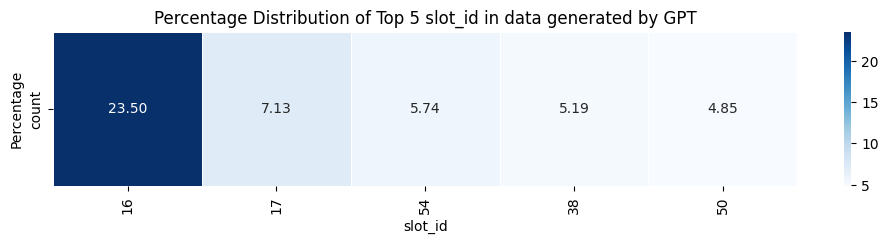

In [ ]:
# Get the top 10 most frequent 'slot_id's in both DataFrames combined
top_5_slot_ids = df_syn_gpt['slot_id'].value_counts().head(5)

# Calculate the percentage for each of the top 10 most frequent 'slot_id's
total_rows = len(df_syn_gpt)
top_5_slot_ids_percentage = (top_5_slot_ids / total_rows) * 100

# Convert the percentages to a DataFrame suitable for heatmap
top_5_slot_ids_percentage_df = top_5_slot_ids_percentage.to_frame().T  # Transpose to have one row

# Plot the heatmap for the top 10 most frequent 'slot_id's with percentages
plt.figure(figsize=(12, 2))  # Adjust figure size
sns.heatmap(top_5_slot_ids_percentage_df, annot=True, cmap='Blues', cbar=True, fmt='.2f', linewidths=0.5)
plt.title('Percentage Distribution of Top 5 slot_id in data generated by GPT')
plt.xlabel('slot_id')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

Excluding few variables as they usually have a feature importance of zero when running models as discussed in week 9

In [ ]:
cols_to_exclude = ['site_id','log_id','pt_d','user_id','task_id','adv_id','adv_prim_id','spread_app_id','inter_type_cd','app_second_class','app_score','hispace_app_tags']
df1 = df_real[[col for col in df_real.columns if col not in cols_to_exclude]]
df_syn_gpt1 = df_syn_gpt[[col for col in df_syn_gpt.columns if col not in cols_to_exclude]]

Combining both real and synthetic data generated by gpt3. Adding a *label_data* variable that shows if it is real(0) or synthetic(1)

In [ ]:
# Use one-hot encoding for categorical variables with fewer unique values
cat_cols = ['ad_click_list_v001', 'ad_click_list_v002','ad_click_list_v003',
                   'ad_close_list_v001', 'ad_close_list_v002', 'ad_close_list_v003',
                    'device_name','device_size', 'net_type',
                   'u_newsCatInterestsST',
                   'gender','city','city_rank','age','residence','series_dev',
                   'series_group','emui_dev','creat_type_cd']
# Assign label 1 for synthetic data and label 0 for real data
df1['label_data'] = 0
df_syn_gpt1['label_data'] = 1
# Combine real and synthetic data
combined_data = pd.concat([df1, df_syn_gpt1], axis=0)

In [ ]:
# Split the combined data into features and target (label)
X = combined_data.drop(columns=['label_data'])
y = combined_data['label_data']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

Running the Catboost model for classification

In [ ]:
cat_features = cat_cols

cat_model = CatBoostClassifier(
    cat_features = cat_features,
    iterations=100,
    depth=5,
    learning_rate=0.01,
    l2_leaf_reg = 10,
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=10
)

model = cat_model
model.fit(X_train, y_train)

# Predictions
y_pred_3 = model.predict(X_test)

# Print standard evaluation
print("\nStandard Classification Report:")
print(classification_report(y_test, y_pred_3, zero_division=1))

0:	learn: 0.6901493	total: 423ms	remaining: 41.9s
10:	learn: 0.6565354	total: 4.04s	remaining: 32.7s
20:	learn: 0.6288450	total: 7.53s	remaining: 28.3s
30:	learn: 0.6030707	total: 12.6s	remaining: 28.1s
40:	learn: 0.5797251	total: 16.1s	remaining: 23.2s
50:	learn: 0.5619727	total: 19.5s	remaining: 18.8s
60:	learn: 0.5501183	total: 23.3s	remaining: 14.9s
70:	learn: 0.5418453	total: 27.9s	remaining: 11.4s
80:	learn: 0.5352408	total: 31.3s	remaining: 7.33s
90:	learn: 0.5273122	total: 34.6s	remaining: 3.42s
99:	learn: 0.5221972	total: 38.7s	remaining: 0us

Standard Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     71702
           1       0.61      0.73      0.67     30039

    accuracy                           0.78    101741
   macro avg       0.74      0.77      0.75    101741
weighted avg       0.80      0.78      0.79    101741



Also running a feature importance to see which variables are making it easy to distinguish between real and synthetic data

In [ ]:
feature_importance = cat_model.get_feature_importance(prettified=True)
print(feature_importance.head(10))

           Feature Id  Importances
0             slot_id    32.453675
1     u_feedLifeCycle    22.570455
2       creat_type_cd    20.814614
3      u_refreshTimes    11.342722
4         device_size     6.461934
5               label     3.390014
6  ad_click_list_v001     2.083722
7  ad_click_list_v002     0.882864
8                 age     0.000000
9              gender     0.000000


Similarly testing out the catboost classifier for real vs RealTabFormer generated data

In [ ]:
# Assign label 1 for synthetic data and label 0 for real data
df_syn_tab1= df_syn_tab[[col for col in df_syn_gpt.columns if col not in cols_to_exclude]]
df1['label_data'] = 0
df_syn_tab1['label_data'] = 1
# Combine real and synthetic data
combined_data1 = pd.concat([df1, df_syn_tab1], axis=0)
combined_data1 = combined_data1.fillna(False)

In [ ]:
# Split the combined data into features and target (label)
X = combined_data1.drop(columns=['label_data'])
y = combined_data1['label_data']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

In [ ]:
cat_features = cat_cols

cat_model = CatBoostClassifier(
    cat_features = cat_features,
    iterations=100,
    depth=5,
    learning_rate=0.01,
    l2_leaf_reg = 10,
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=10
)

model = cat_model
model.fit(X_train, y_train)

# Predictions
y_pred_3 = model.predict(X_test)

# Print standard evaluation
print("\nStandard Classification Report:")
print(classification_report(y_test, y_pred_3, zero_division=1))

0:	learn: 0.6810034	total: 346ms	remaining: 34.3s
10:	learn: 0.5632515	total: 3s	remaining: 24.3s
20:	learn: 0.4742938	total: 5.68s	remaining: 21.4s
30:	learn: 0.4075561	total: 9.9s	remaining: 22s
40:	learn: 0.3554030	total: 12.5s	remaining: 18s
50:	learn: 0.3111953	total: 15.1s	remaining: 14.5s
60:	learn: 0.2703154	total: 18.1s	remaining: 11.6s
70:	learn: 0.2401314	total: 21.7s	remaining: 8.88s
80:	learn: 0.2168334	total: 25s	remaining: 5.87s
90:	learn: 0.1983826	total: 27.8s	remaining: 2.75s
99:	learn: 0.1771887	total: 30.8s	remaining: 0us

Standard Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     71721
           1       0.51      0.99      0.68      6020

    accuracy                           0.93     77741
   macro avg       0.76      0.96      0.82     77741
weighted avg       0.96      0.93      0.94     77741



In [ ]:
feature_importance = cat_model.get_feature_importance(prettified=True)
print(feature_importance.head(10))

             Feature Id  Importances
0    ad_click_list_v003    56.711900
1    ad_click_list_v001    14.237023
2           device_size     7.313174
3           device_name     5.683434
4  u_newsCatInterestsST     3.400500
5                  city     2.926238
6                   age     2.091393
7                 label     2.005426
8       u_feedLifeCycle     1.912247
9    ad_close_list_v003     1.420878


Trying to fit a Random Forest Classifier so convert the click sequence, close sequence and news Cat interests into numerical variables instead like number of ads clicked, number of ads closed so on.

In [ ]:
  # For GPT3
  combined_data['ad_click_count_v001'] = combined_data['ad_click_list_v001'].str.split('^').str.len()
  combined_data['ad_click_count_v002'] = combined_data['ad_click_list_v002'].str.split('^').str.len()
  combined_data['ad_click_count_v003'] = combined_data['ad_click_list_v003'].str.split('^').str.len()
  combined_data['ad_closed_count_v001'] = combined_data['ad_close_list_v001'].str.split('^').str.len()
  combined_data['ad_closed_count_v002'] = combined_data['ad_close_list_v002'].str.split('^').str.len()
  combined_data['ad_closed_count_v003'] = combined_data['ad_close_list_v003'].str.split('^').str.len()
  combined_data['u_newsCat_InterestsST'] = combined_data['u_newsCatInterestsST'].str.split('^').str.len()
  combined_data = combined_data.drop(['ad_click_list_v001', 'ad_click_list_v002', 'ad_click_list_v003', 'ad_close_list_v001', 'ad_close_list_v002', 'ad_close_list_v003','u_newsCatInterestsST'],axis =1)

In [ ]:
  # For RealTabFormer
  combined_data1['ad_click_count_v001'] = combined_data1['ad_click_list_v001'].str.split('^').str.len()
  combined_data1['ad_click_count_v002'] = combined_data1['ad_click_list_v002'].str.split('^').str.len()
  combined_data1['ad_click_count_v003'] = combined_data1['ad_click_list_v003'].str.split('^').str.len()
  combined_data1['ad_closed_count_v001'] = combined_data1['ad_close_list_v001'].str.split('^').str.len()
  combined_data1['ad_closed_count_v002'] = combined_data1['ad_close_list_v002'].str.split('^').str.len()
  combined_data1['ad_closed_count_v003'] = combined_data1['ad_close_list_v003'].str.split('^').str.len()
  combined_data1['u_newsCat_InterestsST'] = combined_data1['u_newsCatInterestsST'].str.split('^').str.len()
  combined_data1 = combined_data1.drop(['ad_click_list_v001', 'ad_click_list_v002', 'ad_click_list_v003', 'ad_close_list_v001', 'ad_close_list_v002', 'ad_close_list_v003','u_newsCatInterestsST'],axis =1)

One hot encoding the rest of the categorical variables

In [ ]:
cat_cols = ['gender','city_rank','age','net_type','series_dev','device_name','emui_dev','city','residence',
            'series_group','creat_type_cd','slot_id']

In [ ]:
combined_data = pd.get_dummies(combined_data, columns=cat_cols)
combined_data1 = pd.get_dummies(combined_data1, columns=cat_cols)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = combined_data.drop(columns=['label_data'])
y = combined_data['label_data']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier (RandomForest in this case)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the classifier performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of classifier in distinguishing real and synthetic data: {accuracy}")

feature_importance = rf_model.feature_importances_
# Convert to a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(importance_df.head(10))

Accuracy of classifier in distinguishing real and synthetic data: 0.7429380196968803
                   Feature  Importance
735             slot_id_16    0.061094
730       creat_type_cd_10    0.050130
4      ad_click_count_v001    0.049767
5      ad_click_count_v002    0.049207
3          u_feedLifeCycle    0.042372
6      ad_click_count_v003    0.041249
10   u_newsCat_InterestsST    0.036588
2           u_refreshTimes    0.035990
716         series_group_3    0.032527
728        creat_type_cd_8    0.030654


The importance of slot_id suggests that GPT-generated data has specific statistical patterns that accumulate, making classification easier.

In [ ]:
X = combined_data1.drop(columns=['label_data'])
y = combined_data1['label_data']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier (RandomForest in this case)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the classifier performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of classifier in distinguishing real and synthetic data: {accuracy}")

feature_importance = rf_model.feature_importances_
# Convert to a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(importance_df.head(10))

Accuracy of classifier in distinguishing real and synthetic data: 0.9639191170795709
                  Feature  Importance
9    ad_closed_count_v003    0.292675
5     ad_click_count_v002    0.122888
7    ad_closed_count_v001    0.099244
4     ad_click_count_v001    0.093700
6     ad_click_count_v003    0.083595
10  u_newsCat_InterestsST    0.078937
8    ad_closed_count_v002    0.064082
2          u_refreshTimes    0.035937
3         u_feedLifeCycle    0.010984
0                   label    0.010327


 For RealTabFormer it was the ad_click_list variables. Most of the real data had a click sequence of 5 ads, whereas RealTabFormer-generated data contained mostly a click sequence of 1 ad.

Conclusion:
- Overall these classification accuracies suggest that it has been easy for the discriminator to tell the real and synthetic data apart.
- The data generated by RealTabFormer appears to create more distinguishable patterns, making it easier for models to separate real from synthetic data. This can be seen in the high classification accuracy (93-96%).
- In contrast, GPT3-generated data results in a lower accuracy (74-78%), which indicates that it is slightly better at capturing the underlying structure of real data. GPT-based models likely perform better because they understand more context and relationships in the data.